In [1]:
import xpress as xp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
%load_ext line_profiler

In [3]:
%matplotlib widget

In [4]:
xp.controls.outputlog = 0
xp.controls.threads = 1
xp.controls.scaling = 0
xp.controls.presolve = 0
xp.controls.feastol = 1.e-7
xp.controls.optimalitytol = 1.e-7
xp.setOutputEnabled(False)

In [5]:
study_path = "D:/Users/gerbauxjul/Documents/6-Etudes Antares/GUA_2018_parc_complet_simplifie_v_8_8"
output_path = study_path+"/output/20240814-1151eco-exportmps"

In [6]:
def retrieve_problem(year,week,output_path,itr=1):
    model = xp.problem()
    model.read(output_path+f"/problem-{year}-{week}--optim-nb-{itr}.mps")
    return(model)

def modify_objective(model, u):
    cst = model.getConstraint()
    binding_id = [i for i in range(len(cst)) if "WeeklyWaterAmount" in cst[i].name]
    model.chgrhs(binding_id,[u])
    return(model)

def milp_version(model):
    vars = model.getVariable()
    interger_vars = [i for i in range(len(vars)) if vars[i].name.strip().split("::")[0] in ['NODU', 'NumberBreakingDownDispatchableUnits', 'NumberStartingDispatchableUnits','NumberStoppingDispatchableUnits']]
    for i in interger_vars:
        model.chgcoltype([vars[i]],'I')
    return(model)

In [7]:
m = retrieve_problem(1,1,output_path,itr=1)

In [8]:
vars = m.getVariable()
len(vars)

13440

In [9]:
cons = m.getConstraint()
len(cons)

15120

In [10]:
m.solve()
m.getObjVal()

2856208.9404531303

In [11]:
df_vars = pd.DataFrame(vars, columns=["names"])
df_vars["split"] = df_vars["names"].apply(lambda x:x.name.strip().split("::"))
df_vars["name_var"] = df_vars["split"].apply(lambda x:x[0])
df_vars["antares_object"] = df_vars["split"].apply(lambda x:x[1].split("<")[0])
df_vars["name_antares_object"] = df_vars["split"].apply(lambda x:x[1].split("<")[1].split(">")[0])
df_vars["subobject"] = df_vars["split"].apply(lambda x:x[2] if len(x)>=4 else "None")
df_vars["time"] = df_vars["split"].apply(lambda x:int(x[-1].split("<")[1].split(">")[0]))
df_vars["time_type"] = df_vars["split"].apply(lambda x:x[-1].split("<")[0])
coltype = []
m.getcoltype(coltype, 0, m.attributes.cols - 1)
df_vars['coltype'] = coltype
bounds = []
m.getlb(bounds, 0, m.attributes.cols - 1)
df_vars['lb'] = bounds
bounds = []
m.getub(bounds, 0, m.attributes.cols - 1)
df_vars['ub'] = bounds
objcoef = []
m.getobj(objcoef,0,m.attributes.cols-1)
df_vars= df_vars.assign(coeff=[objcoef[i] for i in range(m.attributes.cols)])
df_vars = df_vars.assign(sol=[m.getSolution(i) for i in range(m.attributes.cols)])
# df_vars = df_vars.assign(obj = lambda x: np.round(df_vars['sol'],6)*np.round(df_vars['coeff'],6))

In [12]:
df_vars

,names,split,name_var,antares_object,name_antares_object,subobject,time,time_type,coltype,lb,ub,coeff,sol
0,NTCDirect::link<centre$$centre-2>::hour<0> ...,"[NTCDirect, link<centre$$centre-2>, hour<0>]",NTCDirect,link,centre$$centre-2,None,0,hour,C,-60.0,0.000000e+00,0.0,-6.97804
1,NTCDirect::link<centre$$centre-sud-2>::hour<0>...,"[NTCDirect, link<centre$$centre-sud-2>, hour<0>]",NTCDirect,link,centre$$centre-sud-2,None,0,hour,C,-66.0,0.000000e+00,0.0,0.00000
2,NTCDirect::link<centre$$est-2>::hour<0> ...,"[NTCDirect, link<centre$$est-2>, hour<0>]",NTCDirect,link,centre$$est-2,None,0,hour,C,-39.0,0.000000e+00,0.0,-39.00000
3,NTCDirect::link<centre$$est-ce-2>::hour<0> ...,"[NTCDirect, link<centre$$est-ce-2>, hour<0>]",NTCDirect,link,centre$$est-ce-2,None,0,hour,C,-19.0,0.000000e+00,0.0,0.00000
4,NTCDirect::link<centre-2$$reserve>::hour<0> ...,"[NTCDirect, link<centre-2$$reserve>, hour<0>]",NTCDirect,link,centre-2$$reserve,None,0,hour,C,0.0,1.000000e+02,0.0,3.99997
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13435,NumberBreakingDownDispatchableUnits::area<est-...,"[NumberBreakingDownDispatchableUnits, area<est...",NumberBreakingDownDispatchableUnits,area,est-ce-2,ThermalCluster<Albioma*-*CE>,166,hour,C,0.0,0.000000e+00,0.0,0.00000
13436,NODU::area<est-ce-2>::ThermalCluster<Albioma*-...,"[NODU, area<est-ce-2>, ThermalCluster<Albioma*...",NODU,area,est-ce-2,ThermalCluster<Albioma*-*CE>,167,hour,C,0.0,1.000000e+00,0.0,1.00000
13437,NumberStartingDispatchableUnits::area<est-ce-2...,"[NumberStartingDispatchableUnits, area<est-ce-...",NumberStartingDispatchableUnits,area,est-ce-2,ThermalCluster<Albioma*-*CE>,167,hour,C,0.0,1.000000e+20,0.0,0.00000
13438,NumberStoppingDispatchableUnits::area<est-ce-2...,"[NumberStoppingDispatchableUnits, area<est-ce-...",NumberStoppingDispatchableUnits,area,est-ce-2,ThermalCluster<Albioma*-*CE>,167,hour,C,0.0,1.000000e+20,0.0,0.00000


In [13]:
df_vars["name_var"].unique()

array(['NTCDirect', 'DispatchableProduction', 'PositiveUnsuppliedEnergy',
       'NegativeUnsuppliedEnergy', 'NODU',
       'NumberStartingDispatchableUnits',
       'NumberStoppingDispatchableUnits',
       'NumberBreakingDownDispatchableUnits'], dtype=object)

In [18]:
df_vars.subobject.unique()

array(['None', 'ThermalCluster<Albioma*-*CE>',
       'ThermalCluster<Albioma*-*Le*Moule>',
       'ThermalCluster<Albioma*-*Le*Moule*2>',
       'ThermalCluster<Jarry*Sud*2>', 'ThermalCluster<Jarry*Sud*5>',
       'ThermalCluster<PEI*-*Jarry*Clust>'], dtype=object)

In [36]:
df_vars[(df_vars.name_var.isin(['DispatchableProduction','NODU']))&(df_vars.time==1)].sort_values("subobject")

,names,split,name_var,antares_object,name_antares_object,subobject,time,time_type,coltype,lb,ub,coeff,sol
40,DispatchableProduction::area<centre>::ThermalC...,"[DispatchableProduction, area<centre>, Thermal...",DispatchableProduction,area,centre,ThermalCluster<Albioma*-*CE>,1,hour,C,0.0,15.0,89.999456,15.000000
5380,NODU::area<centre>::ThermalCluster<Albioma*-*C...,"[NODU, area<centre>, ThermalCluster<Albioma*-*...",NODU,area,centre,ThermalCluster<Albioma*-*CE>,1,hour,C,0.0,1.0,0.000000,1.000000
59,DispatchableProduction::area<est-ce-2>::Therma...,"[DispatchableProduction, area<est-ce-2>, Therm...",DispatchableProduction,area,est-ce-2,ThermalCluster<Albioma*-*CE>,1,hour,C,0.0,19.0,89.999420,19.000000
12772,NODU::area<est-ce-2>::ThermalCluster<Albioma*-...,"[NODU, area<est-ce-2>, ThermalCluster<Albioma*...",NODU,area,est-ce-2,ThermalCluster<Albioma*-*CE>,1,hour,C,0.0,1.0,0.000000,1.000000
6724,NODU::area<centre>::ThermalCluster<Albioma*-*L...,"[NODU, area<centre>, ThermalCluster<Albioma*-*...",NODU,area,centre,ThermalCluster<Albioma*-*Le*Moule*2>,1,hour,C,0.0,1.0,0.000000,1.000000
42,DispatchableProduction::area<centre>::ThermalC...,"[DispatchableProduction, area<centre>, Thermal...",DispatchableProduction,area,centre,ThermalCluster<Albioma*-*Le*Moule*2>,1,hour,C,0.0,10.0,85.000570,10.000000
12100,NODU::area<est-2>::ThermalCluster<Albioma*-*Le...,"[NODU, area<est-2>, ThermalCluster<Albioma*-*L...",NODU,area,est-2,ThermalCluster<Albioma*-*Le*Moule*2>,1,hour,C,0.0,1.0,0.000000,1.000000
56,DispatchableProduction::area<est-2>::ThermalCl...,"[DispatchableProduction, area<est-2>, ThermalC...",DispatchableProduction,area,est-2,ThermalCluster<Albioma*-*Le*Moule*2>,1,hour,C,0.0,19.0,85.000518,19.000000
11428,NODU::area<est-2>::ThermalCluster<Albioma*-*Le...,"[NODU, area<est-2>, ThermalCluster<Albioma*-*L...",NODU,area,est-2,ThermalCluster<Albioma*-*Le*Moule>,1,hour,C,0.0,1.0,0.000000,1.000000
41,DispatchableProduction::area<centre>::ThermalC...,"[DispatchableProduction, area<centre>, Thermal...",DispatchableProduction,area,centre,ThermalCluster<Albioma*-*Le*Moule>,1,hour,C,0.0,10.0,84.999493,10.000000


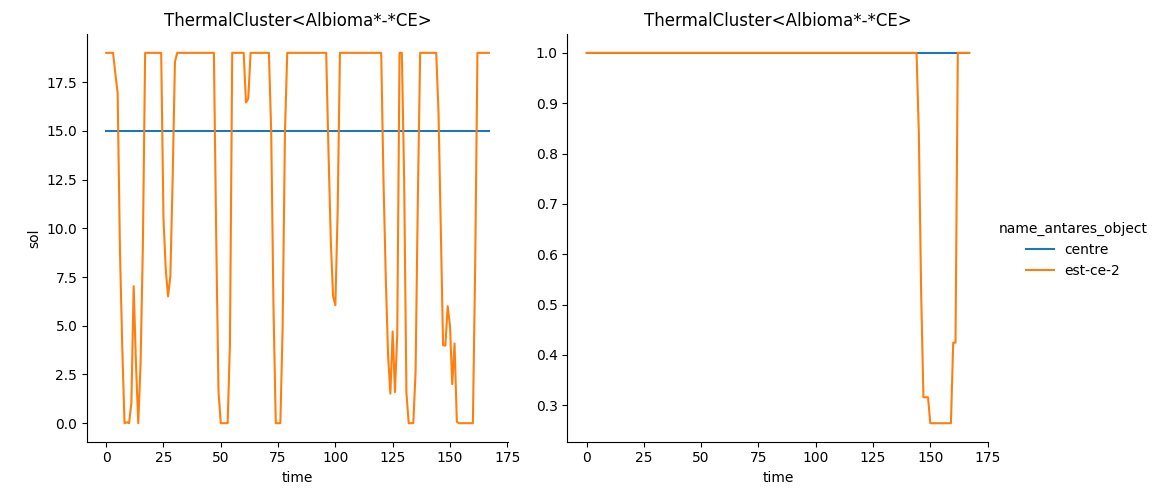

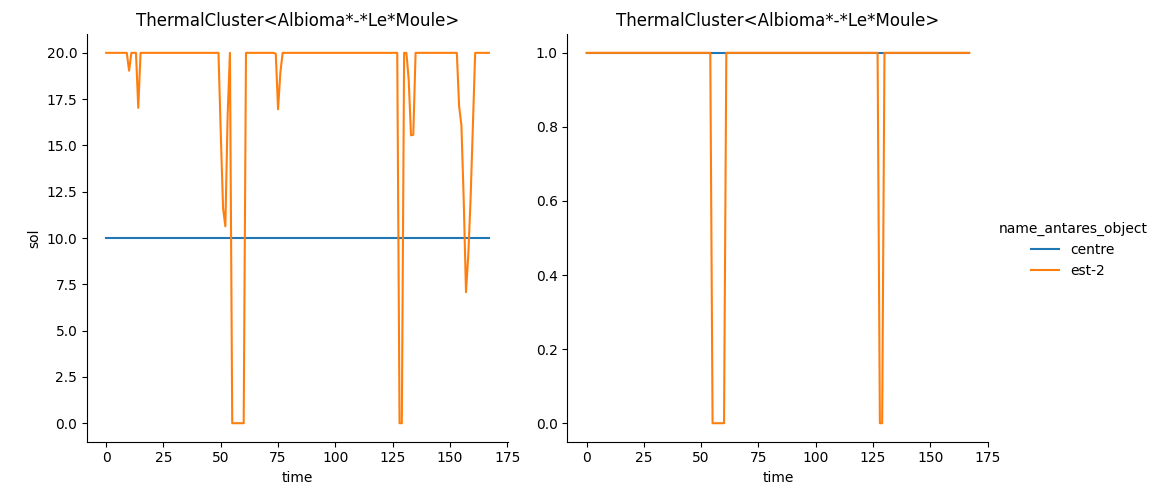

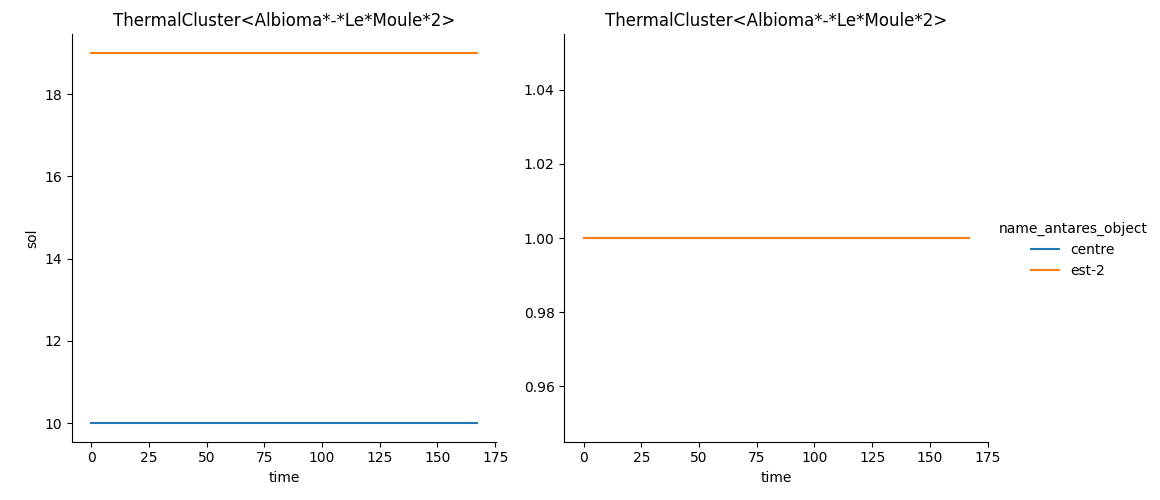

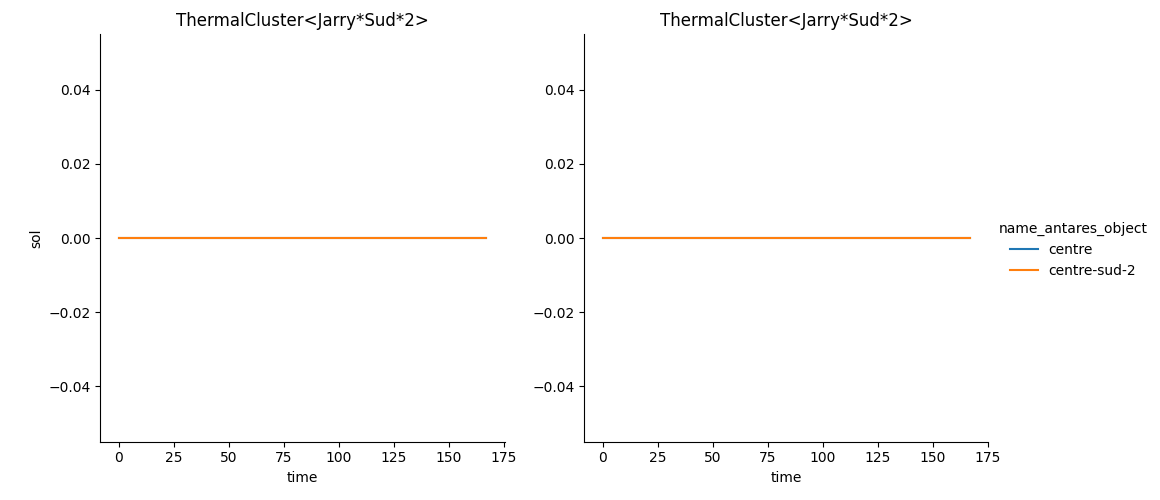

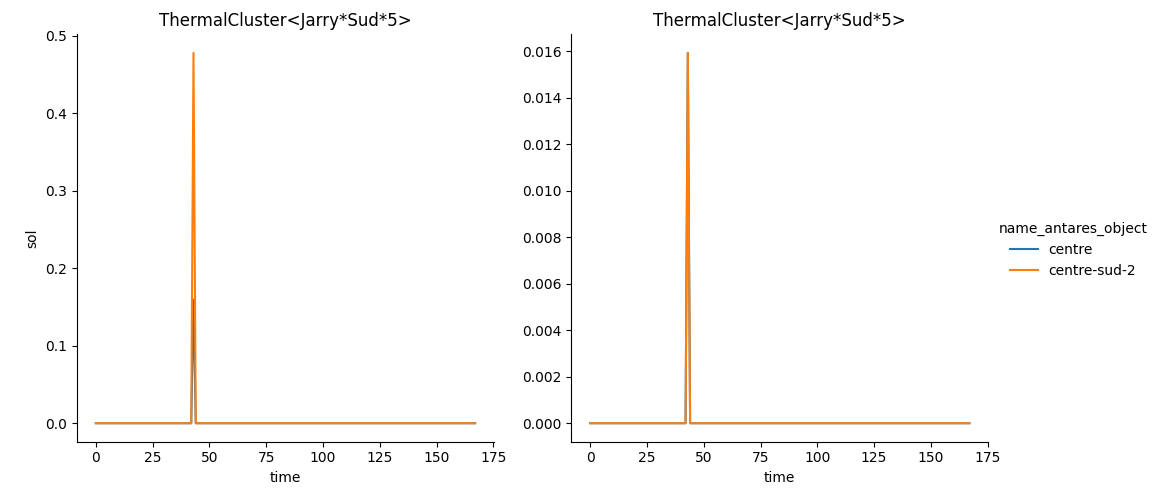

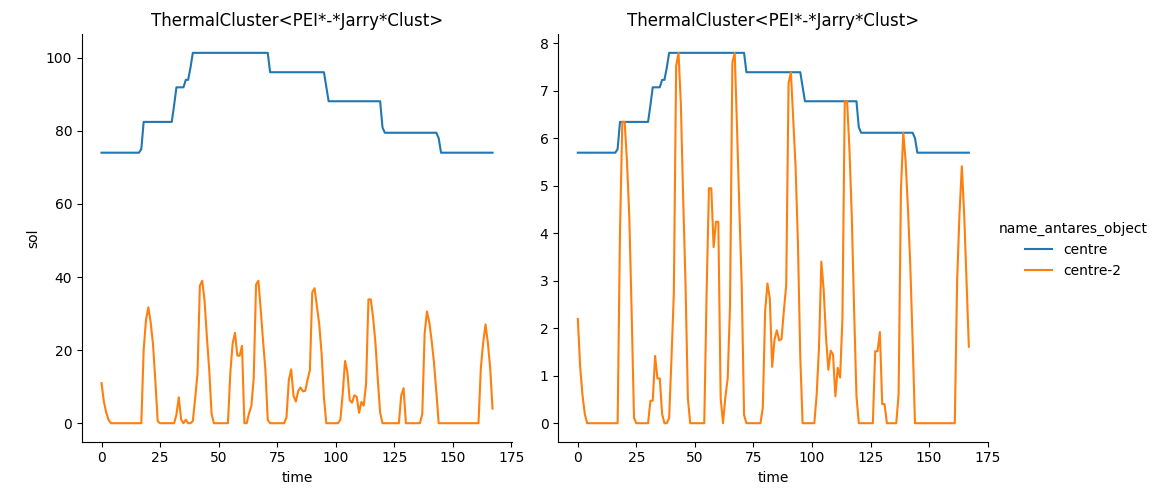

In [38]:
for cluster in ['ThermalCluster<Albioma*-*CE>',
       'ThermalCluster<Albioma*-*Le*Moule>',
       'ThermalCluster<Albioma*-*Le*Moule*2>',
       'ThermalCluster<Jarry*Sud*2>', 'ThermalCluster<Jarry*Sud*5>',
       'ThermalCluster<PEI*-*Jarry*Clust>']:
    sns.relplot(data=df_vars[(df_vars.name_var.isin(['DispatchableProduction','NODU']))&(df_vars.subobject==cluster)],x="time",y="sol",hue="name_antares_object",col="name_var",kind="line", facet_kws=dict(sharey=False)).set(title=cluster)

In [ ]:
df_cons = pd.DataFrame(cons, columns=["names"])
df_cons["split"] = df_cons["names"].apply(lambda x:x.name.strip().split("::"))
df_cons["name_cons"] = df_cons["split"].apply(lambda x:x[0])
df_cons["antares_object"] = df_cons["split"].apply(lambda x:x[1].split("<")[0])
df_cons["name_antares_object"] = df_cons["split"].apply(lambda x:x[1].split("<")[1].split(">")[0] if len(x[1].split("<"))>=2 else "None")
df_cons["time"] = df_cons["split"].apply(lambda x:int(x[-1].split("<")[1].split(">")[0]))
df_cons["time_type"] = df_cons["split"].apply(lambda x:x[-1].split("<")[0])
rhs = []
m.getrhs(rhs, 0, m.attributes.rows - 1)
df_cons["rhs"] = rhs

In [ ]:
df_cons

In [ ]:
df_cons["name_cons"].unique()

In [ ]:
m.write("problem.lp","l")

In [ ]:
23*168